# Определение стоимости автомобиля

### Описание проекта

**Цель**: определить стоимость автомобиля на вторичном рынке.

**Основные этапы полноценного исследования:**
- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков.

**Данные**
- train.csv - информация о характеристиках автомобилей (~440000), которые будут использоваться в качестве обучающих данных.
- test.csv - информация о характеристиках автомобилей (~110000), которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'sellingprice' для каждого автомобиля из этого датасета.
- sample_submission.csv - пример файла предсказаний в правильном формате.
- vin - идентификатор автомобиля в тестовом наборе.
- sellingprice - Целевой признак. Для каждого автомобиля предскажите числовое значение стоимости продажи.

**Описание полей данных**
- Date: Год выпуска автомобиля.
- Make: Марка автомобиля.
- Model: издание автомобиля определенной марки.
- Trim: Уровни отделки салона автомобиля — это просто разные версии модели.
- Body: Тип кузова транспортного средства относится к форме и модели конкретной марки автомобиля.
- Transmission: механизм, который передает мощность от двигателя к колесам.
- VIN: идентификационный номер транспортного средства.
- State: состояние, в котором автомобиль выставлен на аукцион.
- Condition: Состояние автомобилей на момент аукциона.
- Odometer: расстояние, пройденное автомобилем с момента выпуска.
- Color: Цвет кузова автомобиля.
- Interior: Цвет салона автомобиля.
- Seller: Продавец автомобиля, автосалоны.
- sellingprice: цена, по которой автомобиль был продан на аукционе.
- saledate: Дата продажи автомобиля.

In [291]:
!pip install catboost
!pip install shap
!pip install vininfo
!pip install Levenshtein

In [292]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.notebook import tqdm
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import (
    mean_squared_error,
    make_scorer,
    mean_absolute_percentage_error,
    r2_score,
    accuracy_score)
import shap
shap.initjs()

from Levenshtein import distance as lev

from sklearn.neighbors import KNeighborsClassifier
from vininfo import Vin as vin


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import (
    LinearRegression)
import joblib
from joblib import dump, load

from tqdm import notebook
import re
from tqdm.notebook import tqdm
import nltk

### Функции, используемые в проекте

In [293]:
#Функция для проверки пустых срок
def checkNaN(str):
    return str != str

In [294]:
#Функция для парсинга столбца vin
def info_vin(data):
    data['country'] = data['vin']
    for i in range(len(data)):
        data.iloc[i, data.columns.get_loc('country')] = vin(data.iloc[i, -1]).country
        if checkNaN(data.iloc[i, 1]):
            data.iloc[i, data.columns.get_loc('make')] = vin.manufacturer
    return data

In [295]:
#функция для поиска лучшей модели
def find_best(type_model, CV,features_train, target_train, parameters, score, verb,S_value):
    score_mape  = make_scorer(score, greater_is_better=S_value)
    model = type_model()
    grid_search = GridSearchCV(model, parameters, cv = CV, scoring = score_mape)
    if verb:
        grid_search.fit(features_train, target_train, verbose=100000)
    else:
        grid_search.fit(features_train, target_train)
    return grid_search

In [296]:
def model_result(model, columns):

    model_best = model.best_estimator_
    print('Лучший показатель mape = ', np.abs(model.best_score_))
    print('Параметры лучшей модели ', model.best_params_)
    hd = list(columns)
    columns_importance = []
    importance = []
    for i, f in zip(hd, model_best.feature_importances_):
        columns_importance.append(i)
        importance.append(round(f*100,2))
    importance_model = pd.DataFrame([columns_importance, importance]).T
    print(importance_model.sort_values(1, ascending = False))

    return model_best, importance_model


In [297]:
def find_transmission(train_data):
    for i in range(len(train_data)):
        if checkNaN(train_data.iloc[i]['transmission']) :
            tuple_y_m_model = tuple(train_data.iloc[i][['year','make', 'model']].to_numpy())
            if tuple_y_m_model in table_y_m_model.index:
                row =table_y_m_model.loc[tuple_y_m_model].sort_values(ascending = False)
                if row[0]>=0.8:
                    train_data.iloc[i, train_data.columns.get_loc('transmission')] = row.index[0]
    return train_data

In [298]:
def to_lower(data):
    tqdm.pandas()

    data['body'] = data['body'].progress_apply(clear_text)
    data['make'] = data['make'].progress_apply(clear_text)
    data['model'] = data['model'].progress_apply(clear_text)
    data['seller'] = data['seller'].progress_apply(clear_text)
    data['trim'] = data['trim'].progress_apply(clear_text)
    #data['trim'].progress_apply(clear_text)
    #data['trim'].str.lower()
    return data


In [299]:
def data_no_color(data):
    data2 = data.copy()
    data2['color'] = data2['color'].astype(str)
    data2['color'] = data2['color'].where(
    data2['color']=='white',1)
    data2['color'] = data2['color'].where(
    data2['color']==1,0)
    data2['color'] = data2['color'].astype(int)
    data2 = data2.drop(['year_sale', 'interior'],axis = 1)
    return data2

In [300]:
def year_month_age(data):
  data['year_sale'] = pd.to_datetime(data['saledate'], utc = True).dt.year
  data['month_sale'] = pd.to_datetime(data['saledate'], utc = True).dt.month
  data["age_in_days"] = (data['year_sale'] - data['year']) * 365 + pd.to_datetime(
      data['saledate'], utc = True).dt.day
  return data

In [301]:
from datetime import date
date.today().month

8

In [302]:
# функция для отчистки текста
def clear_text(text):
    text = str(text)
    text_clear = re.sub(r"[^a-zA-Z]", ' ' ,  text)
    text_clear = re.sub(r'[^\w\s]', ' ', text).strip()
    text_clear = " ".join(text_clear.split())
    text_clear = text_clear.lower()
    return text_clear

## 1. Загрузка и ознакомление с данными

### 1.1 Загрузка данных

In [321]:
# Загрузка датасета
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')

In [322]:
print('Столбцы в обучающей выборке', list(set(train.columns)))

Столбцы в обучающей выборке ['odometer', 'model', 'condition', 'seller', 'color', 'state', 'year', 'transmission', 'vin', 'make', 'interior', 'body', 'trim', 'sellingprice', 'saledate']


In [323]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


Есть пропуски в данных.

In [324]:
train.head(2)

year  make   model trim   body transmission                vin state  \
0  2011  Ford    Edge  SEL    suv    automatic  2fmdk3jc4bba41556    md   
1  2014  Ford  Fusion   SE  Sedan    automatic  3fa6p0h75er208976    mo   

   condition  odometer  color interior                 seller  sellingprice  \
0        4.2  111041.0  black    black     santander consumer         12500   
1        3.5   31034.0  black    black  ars/avis budget group         14500   

                                  saledate  
0  Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)  
1  Wed Feb 25 2015 02:00:00 GMT-0800 (PST)

Большая часть данных - категориальные. Посмотрим насколько они различны:

In [325]:
columns_with_null = ['state', 'model', 'transmission',
                     'interior', 'body',
                     'color', 'make', 'seller', 'trim']
for column in columns_with_null:
    print(column, 'уникальные значения: ', len(train[column].unique()))

state уникальные значения:  38
model уникальные значения:  960
transmission уникальные значения:  3
interior уникальные значения:  18
body уникальные значения:  86
color уникальные значения:  21
make уникальные значения:  93
seller уникальные значения:  13025
trim уникальные значения:  1923


Довольно много уникальных значений.  

Столбец "vin" содержит много информации, которую можно выташить.

In [326]:
print('Столбец, которого нет в тестовой выборке', list(set(train.columns) - set(test.columns)))

Столбец, которого нет в тестовой выборке ['sellingprice']


Столбцы в тестовом наборе и обучающем одинаковы, столбец "sellingprice" - таргет.

### 1.2 Краткие выводы по имеющимся данным
- в данных есть пропуски (как в обучающем, так и в тестовом наборе).
- 10 из 15 признаков - категориальные
- признак "VIN" - идентификатор машины, он не должен быть частью признаков, по которому будет обучаться модель.
- столбец "sellingprice" - таргет

### 1.3 Разделим обучающий набор на тест и трейн

Прежде работы с данными - разделим набор train на обучающий и тестовый (для оценки работы моделей).
Вместо отдельной валидационной выборки будем использовать кросс-валидацию.

In [327]:
train_data, test_data= train_test_split(
    train, test_size=0.25, random_state=12345)

## 2. Предварительная обработка данных

### 2.1 Проанализируем информацию в столбце 'vin'

In [328]:
test

year       make         model      trim      body transmission  \
0       2005   Cadillac           CTS      Base     Sedan    automatic   
1       2014        GMC  Savana Cargo      2500       Van          NaN   
2       2013     Nissan        Murano         S       SUV    automatic   
3       2013  Chevrolet        Impala  LS Fleet     Sedan    automatic   
4       2013     Nissan         Titan        SV  Crew Cab    automatic   
...      ...        ...           ...       ...       ...          ...   
110053  2011       Jeep      Wrangler     Sport       SUV    automatic   
110054  2014      Lexus        IS 250      Base     sedan    automatic   
110055  2004     Nissan        Maxima    3.5 SL     Sedan    automatic   
110056  2013     Nissan          370Z      Base     coupe       manual   
110057  2012  Chevrolet        Camaro        LS     Coupe          NaN   

                      vin state  condition  odometer   color interior  \
0       1g6dp567450124779    ca        2.7  116970.0  silver    black   
1       1gtw7fca7e1902207    pa        4.4    6286.0   white     gray   
2       jn8az1mw6dw303497    oh        4.6   11831.0    gray    black   
3       2g1wf5e34d1160703    fl        2.3   57105.0  silver    black   
4       1n6aa0ec3dn301209    tn        2.9   31083.0   black    black   
...                   ...   ...        ...       ...     ...      ...   
110053  1j4aa2d17bl584330    ca        3.8   66085.0  orange    black   
110054  jthbf1d23e5007526    fl        4.8   17588.0    gray    black   
110055  1n4ba41e54c831950    va        2.9  124036.0  silver     gray   
110056  jn1az4eh3dm382431    tx        2.2   27169.0       —    black   
110057  2g1fa1e32c9193058    pa        3.7   40399.0    blue    black   

                                                  seller  \
0                                 lexus of stevens creek   
1                                                 u-haul   
2                                     nissan-infiniti lt   
3       onemain rem/auto club of miami inc dba north dad   
4                              nissan north america inc.   
...                                                  ...   
110053                                dtg operations inc   
110054                          lexus financial services   
110055                          shirlie slack mitsubishi   
110056               nissan motor acceptance corporation   
110057                         ingersoll auto of danbury   

                                       saledate  
0       Wed Jan 14 2015 04:30:00 GMT-0800 (PST)  
1       Fri Feb 27 2015 01:00:00 GMT-0800 (PST)  
2       Tue Feb 24 2015 01:30:00 GMT-0800 (PST)  
3       Fri Mar 06 2015 02:00:00 GMT-0800 (PST)  
4       Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)  
...                                         ...  
110053  Thu Jan 15 2015 03:30:00 GMT-0800 (PST)  
110054  Mon Jun 15 2015 11:00:00 GMT-0700 (PDT)  
110055  Thu Feb 05 2015 01:35:00 GMT-0800 (PST)  
110056  Wed Jun 17 2015 03:30:00 GMT-0700 (PDT)  
110057  Fri Jan 09 2015 09:00:00 GMT-0800 (PST)  

[110058 rows x 14 columns]

In [329]:
# Заполним инофрмация о стране производителе и марке машины (если значение пропущено)
print('Пропусков в марке в обучающих данных до обработки vin', sum(train_data['make'].isnull()))
print('Пропусков в марке в тестовых данных до обработки vin', sum(test_data['make'].isnull()))
print('Пропусков в марке в тестовых (без таргетов) данных до обработки vin', sum(test['make'].isnull()))
print('')
train_data = info_vin(train_data)
print('Пропусков в марке в обучающих данных', sum(train_data['make'].isnull()))
test_data = info_vin(test_data)
print('Пропусков в марке в тестовых данных до обработки vin', sum(test_data['make'].isnull()))
test = info_vin(test)
print('Пропусков в марке в тестовых (без таргетов) данных до обработки vin', sum(test['make'].isnull()))

Пропусков в марке в обучающих данных до обработки vin 6033
Пропусков в марке в тестовых данных до обработки vin 2010
Пропусков в марке в тестовых (без таргетов) данных до обработки vin 2061

Пропусков в марке в обучающих данных 0
Пропусков в марке в тестовых данных до обработки vin 0
Пропусков в марке в тестовых (без таргетов) данных до обработки vin 0


### 2.2 Избавление от опечаток/ неявных дубликатов в категориальных данных

In [330]:
# Преобразуем категориальные данные к единому формату
train_data = to_lower(train_data)
test_data = to_lower(test_data)
test = to_lower(test)

print('Уникальных видов кузова', len(train_data['body'].unique()))
print('Уникальных марок ', len(train_data['make'].unique()))
print('Уникальных моделей ', len(train_data['model'].unique()))
print('Уникальных значений продавцов', len(train_data['seller'].unique()))
print('Уникальных значений trim', len(train_data['trim'].unique()))

  0%|          | 0/330177 [00:00<?, ?it/s]

  0%|          | 0/330177 [00:00<?, ?it/s]

  0%|          | 0/330177 [00:00<?, ?it/s]

  0%|          | 0/330177 [00:00<?, ?it/s]

  0%|          | 0/330177 [00:00<?, ?it/s]

  0%|          | 0/110059 [00:00<?, ?it/s]

  0%|          | 0/110059 [00:00<?, ?it/s]

  0%|          | 0/110059 [00:00<?, ?it/s]

  0%|          | 0/110059 [00:00<?, ?it/s]

  0%|          | 0/110059 [00:00<?, ?it/s]

  0%|          | 0/110058 [00:00<?, ?it/s]

  0%|          | 0/110058 [00:00<?, ?it/s]

  0%|          | 0/110058 [00:00<?, ?it/s]

  0%|          | 0/110058 [00:00<?, ?it/s]

  0%|          | 0/110058 [00:00<?, ?it/s]

Уникальных видов кузова 45
Уникальных марок  62
Уникальных моделей  817
Уникальных значений продавцов 11725
Уникальных значений trim 1764


Найдем значение, для которых расстояние Левенштейна ==1, для значений столбца model (в столбцах make и body дубликатов не обнаружено).
В столбцах seller и trim слишком много уникальных значений и абривиатур, которые различаются всего двумя символами, но при этом не являются дубликатами.

In [331]:
# рассчитаем расстояние Левенштейна на примере 100 строк
dup = []
for j in range(100):
    for i in range(100):
        r = lev(str(train_data.iloc[j]['model']),
                str(train_data.iloc[i]['model']))
        if r ==1:
            t = (r, train_data.iloc[j]['model'], train_data.iloc[i]['model'])
            if t not in dup:
                dup.append(t)
dup

[(1, 'mkx', 'mdx'),
 (1, 'e class', 'c class'),
 (1, 'e class', 'm class'),
 (1, 'c class', 'e class'),
 (1, 'c class', 'm class'),
 (1, 'cx 9', 'cx 5'),
 (1, 'xb', 'x5'),
 (1, 'cx 5', 'cx 9'),
 (1, 'm class', 'e class'),
 (1, 'm class', 'c class'),
 (1, 'mdx', 'mkx'),
 (1, 'x5', 'xb'),
 (1, '3 series', '5 series'),
 (1, '5 series', '3 series')]

Кажется так, выявить дубликаты не получится.

### 2.3 Анализ пропусков  и поиск аномалий

In [332]:
train_data.isnull().sum()

year                0
make                0
model               0
trim                0
body                0
transmission    38550
vin                 0
state               0
condition        7081
odometer           50
color             439
interior          439
seller              0
sellingprice        0
saledate            0
country             0
dtype: int64

#### 2.3.1 Пропуски в color и interior

Проверим есть ли зависимость пропусков в строках color и interior

In [333]:
len(train_data[train_data['interior'].isnull() & train_data['color'].isnull()])

439

Кажется, если нет информации о цвете кузова, о цвете салона тоже нет данных.

In [334]:
print('Цвета салона', train_data['interior'].unique())
print('Цвета кузова', train_data['color'].unique())

Цвета салона ['black' 'beige' 'tan' 'gray' 'brown' '—' nan 'silver' 'blue' 'orange'
 'purple' 'green' 'red' 'gold' 'off-white' 'burgundy' 'white' 'yellow']
Цвета кузова ['white' 'brown' 'silver' 'red' 'blue' '—' 'black' 'burgundy' 'gray'
 'green' 'beige' 'yellow' nan 'gold' 'off-white' 'orange' 'charcoal'
 'purple' 'turquoise' 'pink' 'lime']


В цветах салона и кузова есть "-".
Используем прочерк как заглушку.

In [335]:
train_data['interior'] = train_data['interior'].fillna('-')
train_data['color'] = train_data['color'].fillna('-')

# Сделаем то же самое в тестовом наборе и наборе test_data
test['interior'] = test['interior'].fillna('-')
test['color'] = test['color'].fillna('-')

test_data['interior'] = test_data['interior'].fillna('-')
test_data['color'] = test_data['color'].fillna('-')

#### 2.3.2 Пропуски в transmission

In [338]:
print('Количество пропусков в столбце transmission (train_data)',
      train_data['transmission'].isnull().sum())

print('Количество пропусков в столбце transmission (test_data)',
      test_data['transmission'].isnull().sum())

print('Количество пропусков в столбце transmission (test)',
      test['transmission'].isnull().sum())

print('Уникальные значения transmission',
      train_data['transmission'].unique())

Количество пропусков в столбце transmission (train_data) 38550
Количество пропусков в столбце transmission (test_data) 12911
Количество пропусков в столбце transmission (test) 13011
Уникальные значения transmission ['automatic' 'manual' nan]


In [339]:
# Группируем информацию в таблицу по году, марке и модели
table_y_m_model = train_data.groupby(
    ['year','make', 'model'])['transmission'].value_counts(normalize=True)

train_data = find_transmission(train_data)
test_data = find_transmission(test_data)
test = find_transmission(test)

In [340]:
print('Количество пропусков в столбце transmission (train_data) после обработки',
      train_data['transmission'].isnull().sum())

print('Количество пропусков в столбце transmission (test_data) после обработки',
      test_data['transmission'].isnull().sum())

print('Количество пропусков в столбце transmission (test) после обработки',
      test['transmission'].isnull().sum())

Количество пропусков в столбце transmission (train_data) после обработки 1464
Количество пропусков в столбце transmission (test_data) после обработки 497
Количество пропусков в столбце transmission (test) после обработки 508


In [345]:
train_data['transmission'].value_counts()

automatic    318421
manual        10292
Name: transmission, dtype: int64

Пропуски еще остались. Заполним их : "automatic"( как самым встречающимся классом)

In [346]:
train_data['transmission'] = train_data['transmission'].fillna('automatic')
test['transmission'] = test['transmission'].fillna('automatic')
test_data['transmission'] = test_data['transmission'].fillna('automatic')

#### 2.2.3 Пропуски condition

In [347]:
train_data.isnull().sum()

year               0
make               0
model              0
trim               0
body               0
transmission       0
vin                0
state              0
condition       7081
odometer          50
color              0
interior           0
seller             0
sellingprice       0
saledate           0
country            0
dtype: int64

<Axes: >

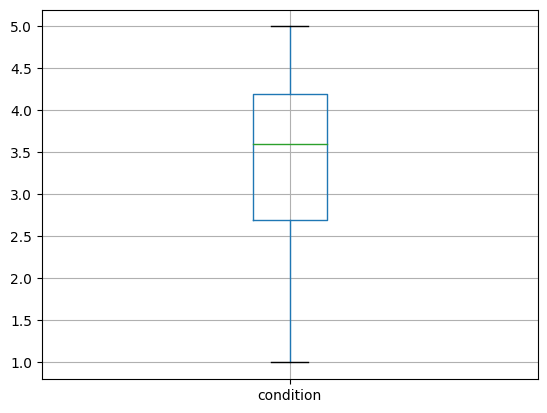

In [274]:
train_data.boxplot(column = 'condition')

In [275]:
train_data['condition'].describe(include ='all')

count    323096.000000
mean          3.426098
std           0.949497
min           1.000000
25%           2.700000
50%           3.600000
75%           4.200000
max           5.000000
Name: condition, dtype: float64

<Axes: xlabel='condition', ylabel='sellingprice'>

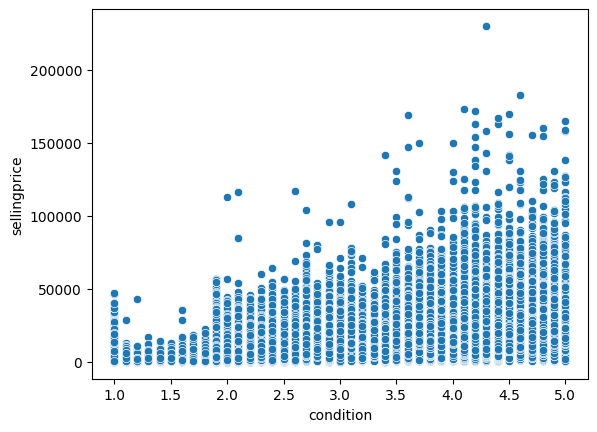

In [276]:
sns.scatterplot(data =train_data, x = 'condition', y = 'sellingprice')

Аномалий не выявлено. Заполним пропуски - значением медианы (по данным обучающей выборке)

In [348]:
condition_median =  train_data['condition'].median()
train_data['condition'] = train_data['condition'].fillna(
   condition_median)

test_data['condition'] = test_data['condition'].fillna(
    condition_median)

test['condition'] = test['condition'].fillna(
    condition_median)

#### 2.2.4 Пропуски в odometr

array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'condition'}>],
       [<Axes: title={'center': 'odometer'}>,
        <Axes: title={'center': 'sellingprice'}>]], dtype=object)

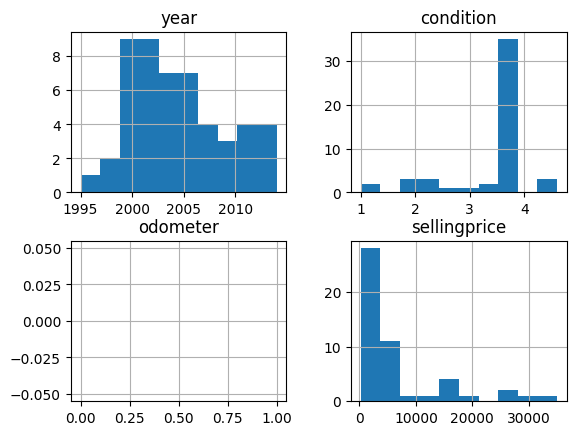

In [350]:
train_data[train_data['odometer'].isnull()].hist()

In [356]:
train_data[train_data['odometer'].isnull()].describe()

year  condition  odometer  sellingprice
count    50.000000   50.00000       0.0     50.000000
mean   2004.480000    3.31800       NaN   6120.220000
std       4.794725    0.75314       NaN   8588.279867
min    1995.000000    1.00000       NaN    250.000000
25%    2001.000000    3.60000       NaN    650.000000
50%    2003.000000    3.60000       NaN   2300.000000
75%    2007.750000    3.60000       NaN   5900.000000
max    2014.000000    4.60000       NaN  35000.000000

In [357]:
train_data[train_data['condition'] == 3.6].describe()

year     condition       odometer   sellingprice
count  20656.000000  2.065600e+04   20621.000000   20656.000000
mean    2008.937548  3.600000e+00   81394.384074   11507.875775
std        4.246139  8.881999e-16   53847.059970    8456.522355
min     1985.000000  3.600000e+00       1.000000     175.000000
25%     2006.000000  3.600000e+00   38633.000000    5300.000000
50%     2010.000000  3.600000e+00   69641.000000   10500.000000
75%     2012.000000  3.600000e+00  113632.000000   15500.000000
max     2015.000000  3.600000e+00  999999.000000  169000.000000

<Axes: >

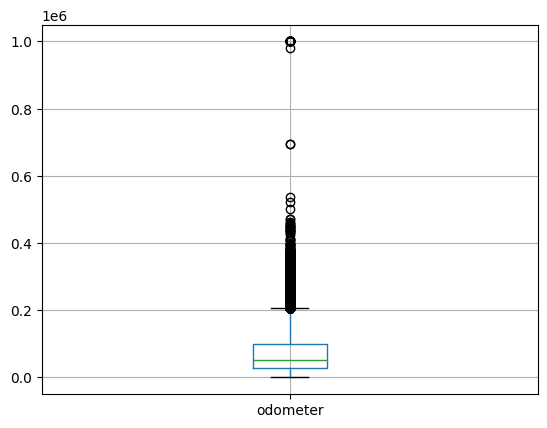

In [360]:
train_data.boxplot(column = 'odometer')

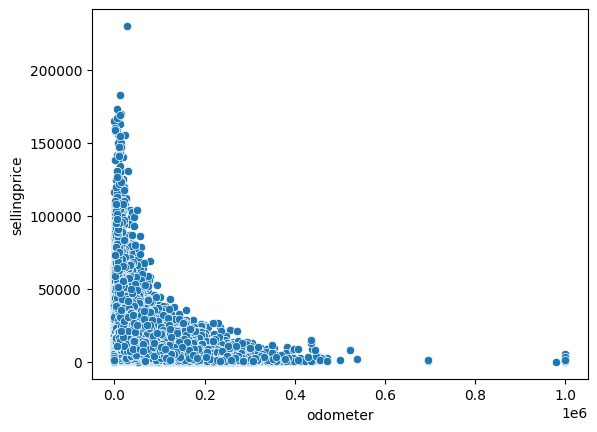

In [361]:
sns.scatterplot(data =train_data, x = 'odometer', y = 'sellingprice')
plt.show()

Удалим значения пробега больше 500000.

In [362]:
train_data = train_data[train_data['odometer']<500000]

In [363]:
train_data['odometer'].describe(include ='all')

count    330084.000000
mean      68157.561566
std       52411.692516
min           1.000000
25%       28259.000000
50%       52038.000000
75%       99187.000000
max      471114.000000
Name: odometer, dtype: float64

In [364]:
odometr_median = train_data.loc[train_data['odometer']<500000, 'odometer'].median()

train_data['odometer'] = train_data['odometer'].fillna(
    odometr_median)

test_data['odometer'] = test_data['odometer'].fillna(
    odometr_median)

test['odometer'] = test['odometer'].fillna(
    odometr_median)

#### 2.2.5 Пропуски в body, model

In [366]:
train_data['body'].describe(include ='all')

count     330084
unique        45
top        sedan
freq      142911
Name: body, dtype: object

Тип кузова транспортного средства относится к форме и модели конкретной марки автомобиля.
Необходимо проверить корреляцию.
Но для начала посмотрим количество строк, где есть пропуски и в фирме, и в модели и в кузове

In [367]:
print('Количество строк с пропусками в типе кузова и модели',
      len(train_data[train_data['body'].isnull() &  train_data['model'].isnull()]))

Количество строк с пропусками в типе кузова и модели 0


In [368]:
test_data.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
country         0
dtype: int64

In [370]:
train_data['body'] = train_data['body'].fillna('')
train_data['make'] = train_data['make'].fillna('')
train_data['model'] = train_data['model'].fillna('')

test_data['body'] = test_data['body'].fillna('')
test_data['make'] = test_data['make'].fillna('')
test_data['model'] = test_data['model'].fillna('')

test['body'] = test['body'].fillna('')
test['make'] = test['make'].fillna('')
test['model'] = test['model'].fillna('')

#### 2.2.6 Пропуски в trim

In [371]:
train_data['trim'].sort_values().unique()[:10]

array(['', '1', '1 6', '1 6 base', '1 6 s', '1 6 s plus', '1 6 sl',
       '1 6 sv', '1 8', '1 8 base'], dtype=object)

Заполним пропуски заглушкой ""

In [372]:
train_data['trim'] = train_data['trim'].fillna('')
test_data['trim'] = test_data['trim'].fillna('')
test['trim'] = test['trim'].fillna('')

Все пропуски заполнены.
Данных в обучающем наборе (train_data) было 330177.

In [373]:
print('% данных, которые удалили', 100-len(train_data)/330177*100)

% данных, которые удалили 0.028166710582510746


#### 2.2.7 Проверка на аномалии в year

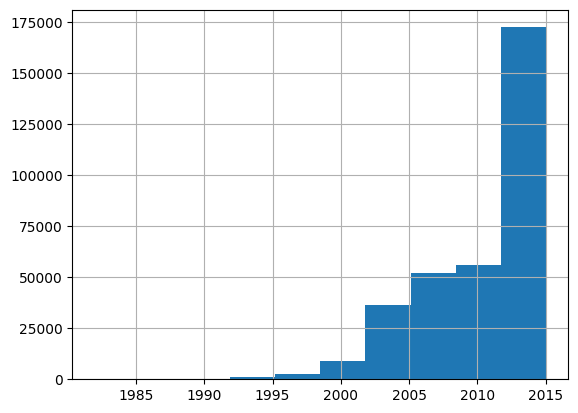

In [136]:
train_data['year'].hist()
plt.show()

Аномалий не обнаружено.

#### 2.2.8 Проверка на аномалии в sellingprice

In [137]:
train_data['sellingprice']

187081    45600
372802    41750
207157     9800
210724    26100
417757    18500
          ...  
347556    51000
395393     1600
392477     9000
77285     35400
217570    21000
Name: sellingprice, Length: 330177, dtype: int64

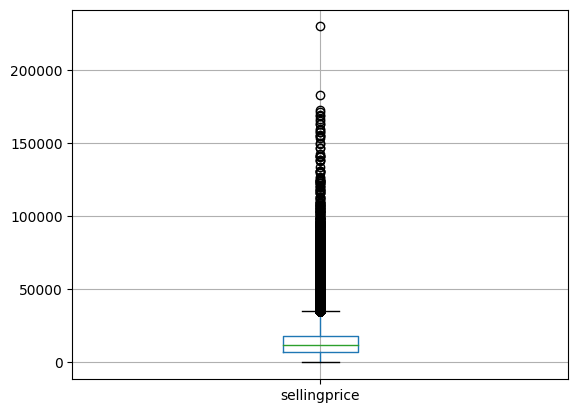

In [138]:
train_data.boxplot(column = 'sellingprice')
plt.show()

In [374]:
train_data_overprice = train_data.copy()
test_data_overprice = test_data.copy()

train_data= train_data[train_data['sellingprice']<175000]

In [140]:
train_data_overprice.describe()

year      condition       odometer   sellingprice
count  330177.000000  330177.000000  330127.000000  330177.000000
mean     2010.041620       3.429828   68272.665844   13603.132995
std         3.978586       0.939598   53391.869134    9748.929438
min      1982.000000       1.000000       1.000000       1.000000
25%      2007.000000       2.700000   28262.000000    6900.000000
50%      2012.000000       3.600000   52046.000000   12100.000000
75%      2013.000000       4.200000   99201.500000   18200.000000
max      2015.000000       5.000000  999999.000000  230000.000000

<Axes: >

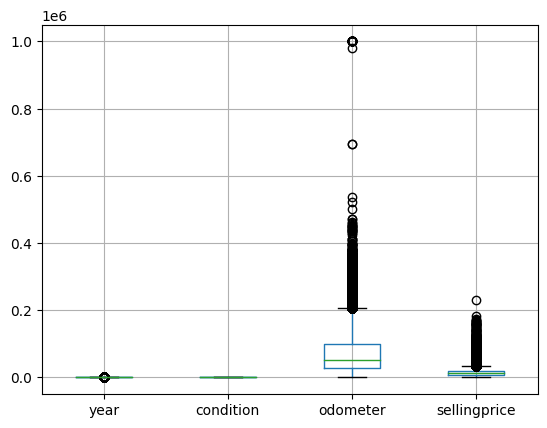

In [141]:
train_data_overprice.boxplot()

### 2.3 Проверка на явные дубликаты в данных

In [375]:
print('Количество дуликатов в train_data', train_data.duplicated().sum())
print('Количество дуликатов в test_data', test_data.duplicated().sum())
print('Количество дуликатов в test', test.duplicated().sum())

Количество дуликатов в train_data 0
Количество дуликатов в test_data 0
Количество дуликатов в test 0


Явных дубликатов нет.

## 3. Новые признаки

#### 3.1 Добавим в признаки год и месяц продажи авто, а также возраст автомобиля

In [376]:
train_data.head(5)

year     make             model        trim      body transmission  \
187081  2015     ford        expedition  el limited       suv    automatic   
372802  2012     ford  f 250 super duty      lariat  crew cab    automatic   
207157  2006     ford  f 250 super duty      lariat  crew cab    automatic   
210724  2013  lincoln               mkx        base       suv    automatic   
417757  2012  hyundai             azera        base     sedan    automatic   

                      vin state  condition  odometer   color interior  \
187081  1fmjk2at5fef15828    mo        5.0   16050.0   white    black   
372802  1ft7w2bt3cea85732    tx        4.1   26629.0   brown    black   
207157  1ftsw21p06eb79764    nc        1.8  142579.0   brown    beige   
210724  2lmdj8jk2dbl38484    mi        2.9   25931.0  silver    black   
417757  kmhfg4jg5ca132982    tn        4.8   40709.0  silver      tan   

                               seller  sellingprice  \
187081                kc landsmen ars         45600   
372802           steve landers toyota         41750   
207157                   gm financial          9800   
210724  ford motor credit company llc         26100   
417757          hyundai motor finance         18500   

                                       saledate        country  
187081  Wed Jun 03 2015 03:00:00 GMT-0700 (PDT)  United States  
372802  Wed Jan 21 2015 02:20:00 GMT-0800 (PST)  United States  
207157  Tue Dec 30 2014 09:15:00 GMT-0800 (PST)  United States  
210724  Thu Jun 18 2015 02:00:00 GMT-0700 (PDT)         Canada  
417757  Wed May 27 2015 03:00:00 GMT-0700 (PDT)    South Korea

In [377]:
# Год и месяц продаж важны (инфляция и сезонность)
train_data =year_month_age(train_data)
test_data =year_month_age(test_data)
test =year_month_age(test)
train_data_overprice = year_month_age(train_data_overprice)

### 3.2 Расчитаем пробег автомобиля в день (такси/авто для личного пользования)

In [378]:
train_data['mileage_per_day'] = train_data['odometer']/train_data['age_in_days']

test_data['mileage_per_day'] = test_data['odometer']/test_data['age_in_days']

test['mileage_per_day'] = test['odometer']/test['age_in_days']

train_data_overprice['mileage_per_day'] = train_data_overprice['odometer']/train_data_overprice['age_in_days']

### 3.3 Масштабируем данные

In [379]:
#Масштабирование численных признаков
num_features = train_data.drop('sellingprice',
                               axis = 1).select_dtypes(include=np.number).columns
scaler = StandardScaler().fit(train_data[num_features])
train_data[num_features] = scaler.transform(train_data[num_features])
test_data[num_features] = scaler.transform(test_data[num_features])
test[num_features] = scaler.transform(test[num_features])
train_data_overprice[num_features] = scaler.transform(train_data_overprice[num_features])

In [380]:
dump(scaler, 'std_scaler.save')

['std_scaler.save']

### 3.4 Выделим признаки для обучения модели

In [381]:
train_data.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'sellingprice',
       'saledate', 'country', 'year_sale', 'month_sale', 'age_in_days',
       'mileage_per_day'],
      dtype='object')

In [382]:
feature_train_data = train_data.drop(columns = ['sellingprice', 'vin', 'saledate'], axis = 1)
target_train_data = train_data['sellingprice']

feature_test_data = test_data.drop(columns = ['sellingprice', 'vin', 'saledate'], axis = 1)
target_test_data = test_data['sellingprice']

feature_test = test.drop(columns = [ 'vin', 'saledate'], axis = 1)

In [383]:
features_ohe = list(set(feature_train_data.columns) - set(num_features))
features_ohe

['seller',
 'model',
 'color',
 'state',
 'country',
 'transmission',
 'make',
 'interior',
 'body',
 'trim']

## 4. Анализ на мультиколлениарность

In [394]:
feature_train_data.describe()

year     condition      odometer     year_sale    month_sale  \
count  3.300820e+05  3.300820e+05  3.300820e+05  3.300820e+05  3.300820e+05   
mean  -2.403025e-14  2.039827e-16  9.704033e-17  3.048682e-13 -1.007213e-16   
std    1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00   
min   -7.050313e+00 -2.586692e+00 -1.300415e+00 -3.048526e+00 -8.673128e-01   
25%   -7.650216e-01 -7.771120e-01 -7.612547e-01  3.280274e-01 -8.673128e-01   
50%    4.920366e-01  1.809007e-01 -3.075625e-01  3.280274e-01 -5.588842e-01   
75%    7.434483e-01  8.195759e-01  5.920278e-01  3.280274e-01  6.748301e-01   
max    1.246272e+00  1.671143e+00  7.688296e+00  3.280274e-01  2.525402e+00   

       mileage_per_day  
count     3.300820e+05  
mean     -6.326026e-18  
std       1.000002e+00  
min      -3.087461e-01  
25%      -1.055431e-01  
50%      -8.643575e-02  
75%      -5.677737e-02  
max       7.811125e+01

                     year  condition  odometer  year_sale  month_sale  \
year             1.000000   0.533168 -0.788700   0.116826   -0.048590   
condition        0.533168   1.000000 -0.530142   0.020994   -0.004481   
odometer        -0.788700  -0.530142  1.000000  -0.090843    0.044388   
year_sale        0.116826   0.020994 -0.090843   1.000000   -0.824306   
month_sale      -0.048590  -0.004481  0.044388  -0.824306    1.000000   
age_in_days     -0.997340  -0.534841  0.786683  -0.044339   -0.011902   
mileage_per_day  0.105554   0.055025 -0.065921  -0.023974    0.054034   

                 age_in_days  mileage_per_day  
year               -0.997340         0.105554  
condition          -0.534841         0.055025  
odometer            0.786683        -0.065921  
year_sale          -0.044339        -0.023974  
month_sale         -0.011902         0.054034  
age_in_days         1.000000        -0.108334  
mileage_per_day    -0.108334         1.000000  


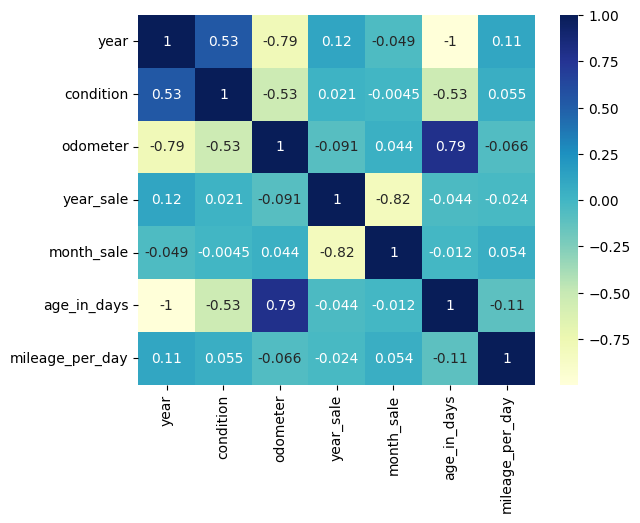

In [385]:
print(feature_train_data.corr())
df_plot = sns.heatmap(feature_train_data.corr(), cmap="YlGnBu", annot=True)
plt.show()

Большие значения корреляции (>abs(0.8)) - год выпуска и возраст автомобиля (с минусом), среди численных признаков коррелирующие - пробег и возраст автомобиля.

In [386]:
feature_train_data = feature_train_data.drop(columns = ['age_in_days'], axis = 1)
feature_test_data = feature_test_data.drop(columns = ['age_in_days'], axis = 1)
feature_test = feature_test.drop(columns = ['age_in_days'], axis = 1)

In [387]:
feature_train_data.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'country',
       'year_sale', 'month_sale', 'mileage_per_day'],
      dtype='object')

## 5 Отбор признаков для обучения модели

#### 5.1 LinearRegression

Попробуем убрать некторые добавочные признаки и посмотреть на результат

In [ ]:
add_features = list(set(['month_sale',
       'age_in_days', 'mileage_per_day']))
first_features = list(set(num_features) - set(add_features))
num_features2 = first_features.copy()
parameters = {}
for i in range(len(add_features)):
    num_features2.append(add_features[i])
    model_LR = find_best(LinearRegression, 5,feature_train_data[num_features2],target_train_data, parameters, r2_score, False, True)
    print('R2=',model_LR.best_score_, 'features:', num_features2)

R2= 0.43349068551430603 features: ['odometer', 'year', 'condition', 'year_sale', 'age_in_days']
R2= 0.4338502409825299 features: ['odometer', 'year', 'condition', 'year_sale', 'age_in_days', 'month_sale']
R2= 0.43453224113590655 features: ['odometer', 'year', 'condition', 'year_sale', 'age_in_days', 'month_sale', 'mileage_per_day']


Добавленные признаки повышают метрику R2, а значит долю дисперсии зависимой переменной, объясняемой рассматриваемой моделью.

### 5.2 Добавим категорию автомобиля: от эконома до премиум

In [70]:
import plotly.express as px
df = feature_train_data.copy()
df['class'] = 0
fig = px.histogram(target_train_data, x="sellingprice")
fig.show()

In [71]:
df.loc[target_train_data<10000, 'class'] = 4
fig = px.histogram(target_train_data[target_train_data <10000])
fig.show()

In [72]:
df.loc[(target_train_data>=10000) & (target_train_data<40000), 'class'] = 3
fig = px.histogram(target_train_data[(target_train_data>=10000) & (target_train_data<40000)])
fig.show()

In [73]:
df.loc[(target_train_data>=40000) & (target_train_data<80000), 'class'] = 2
fig = px.histogram(target_train_data[(target_train_data>=40000) & (target_train_data<80000)])
fig.show()

In [74]:
df.loc[(target_train_data>80000) & (target_train_data<120000), 'class'] = 1
fig = px.histogram(target_train_data[(target_train_data>=80000) & (target_train_data<120000)])
fig.show()

In [75]:
df.loc[(target_train_data>=120000) , 'class'] = 0
fig = px.histogram(target_train_data[(target_train_data>=120000)])
fig.show()

In [76]:
df.groupby('class')['model'].count()

class
0        62
1       227
2      5251
3    199331
4    125211
Name: model, dtype: int64

In [77]:
df[df['class'] < 3] = 3
df.groupby('class')['model'].count()

class
3    204871
4    125211
Name: model, dtype: int64

In [78]:
import plotly.express as px
df_test = feature_test_data.copy()
df_test['class'] = 0
fig = px.histogram(target_test_data, x="sellingprice")
fig.show()

Распределение похоже на то, что наблюдали на train. Посмотрим -есть ли выбросы в тесте

In [79]:
df_test.loc[target_test_data<10000, 'class'] = 4
df_test.loc[(target_test_data>=10000) & (target_test_data<40000), 'class'] = 3
df_test.loc[(target_test_data>=40000), 'class'] = 3

In [80]:
df_test.groupby('class')['model'].count()

class
3    68071
4    41988
Name: model, dtype: int64

In [81]:
from sklearn.preprocessing import OrdinalEncoder
class_train= df['class']
class_test = df_test['class']

f_class_train = feature_train_data.copy()
f_class_test = feature_test_data.copy()
f_class_test_test = feature_test.copy()

features_ohe_class =list(set(f_class_train.columns)- set(f_class_train.select_dtypes(include=np.number).columns))
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
enc.fit(feature_train_data[features_ohe_class])
f_class_train[features_ohe_class]= enc.transform(f_class_train[features_ohe_class])

In [82]:
f_class_test[features_ohe_class]= enc.transform(f_class_test[features_ohe_class])
f_class_test

year  make  model    trim  body  transmission  state  condition  \
47461  -3.027727   9.0  645.0  1000.0   5.0           1.0   14.0   0.180901   
355108 -0.262198   8.0  664.0  1650.0  35.0           1.0   33.0   0.713130   
392123  0.743448  16.0  307.0  1308.0  36.0           1.0   13.0   0.926022   
21513  -0.010787  43.0  306.0  1308.0   7.0           1.0    8.0  -1.628679   
339202  0.743448  58.0  652.0  1031.0  28.0           1.0    8.0  -0.138437   
...          ...   ...    ...     ...   ...           ...    ...        ...   
429244  0.743448   8.0  450.0  1059.0  36.0           1.0   22.0   0.819576   
407489 -0.765022  59.0  505.0   105.0  24.0           1.0   15.0  -1.096450   
72464  -1.267845  48.0  501.0  1147.0  29.0           1.0   28.0  -1.522233   
191816  0.492037  53.0  712.0   539.0  24.0           1.0   15.0  -0.990004   
53749  -0.010787  11.0  571.0  1394.0   7.0           2.0    5.0  -1.096450   

        odometer  color  interior   seller  country  year_sale  month_sale  \
47461   2.047411   19.0       2.0   7461.0      9.0  -3.048526    2.525402   
355108  0.871928   16.0       2.0   3488.0     15.0   0.328027    0.674830   
392123 -0.646037   16.0       2.0   4319.0      9.0   0.328027   -0.558884   
21513   0.250863    2.0       7.0   7629.0     15.0  -3.048526    2.525402   
339202  0.220641    2.0       7.0    250.0     15.0   0.328027    0.674830   
...          ...    ...       ...      ...      ...        ...         ...   
429244 -0.768834    2.0       7.0   8538.0     15.0   0.328027    0.366402   
407489  0.993675    2.0      14.0   4312.0      9.0   0.328027   -0.867313   
72464   1.867355    3.0       7.0      0.0      2.0   0.328027   -0.250456   
191816 -0.636306    2.0       2.0  10852.0      8.0   0.328027    0.366402   
53749  -0.399565    3.0       7.0   9026.0      9.0   0.328027   -0.558884   

        mileage_per_day  
47461         -0.102082  
355108        -0.062500  
392123        -0.071919  
21513         -0.057024  
339202         0.035963  
...                 ...  
429244        -0.089847  
407489        -0.082403  
72464         -0.074683  
191816        -0.100108  
53749         -0.110025  

[110059 rows x 16 columns]

In [83]:
f_class_test_test[features_ohe_class]= enc.transform(f_class_test_test[features_ohe_class])
f_class_test_test

year  make  model    trim  body  transmission  state  condition  \
0      -1.267845   7.0  191.0   539.0  36.0           1.0    3.0  -0.777112   
1       0.994860  19.0  641.0   165.0  42.0           1.0   28.0   1.032468   
2       0.743448  43.0  495.0  1257.0  39.0           1.0   24.0   1.245359   
3       0.743448   8.0  382.0  1063.0  36.0           1.0    5.0  -1.202895   
4       0.743448  43.0  720.0  1485.0   7.0           1.0   32.0  -0.564220   
...          ...   ...    ...     ...   ...           ...    ...        ...   
110053  0.240625  27.0  775.0  1417.0  39.0           1.0    3.0   0.393792   
110054  0.994860  32.0  393.0   539.0  36.0           1.0    5.0   1.458251   
110055 -1.519257  43.0  460.0   228.0  36.0           1.0   35.0  -0.564220   
110056  0.743448  43.0   20.0   539.0   6.0           2.0   33.0  -1.309341   
110057  0.492037   8.0  128.0  1059.0   6.0           0.0   28.0   0.287347   

        odometer  color  interior   seller  country  year_sale  month_sale  \
0       0.931323   16.0       2.0   6367.0     15.0   0.328027   -0.867313   
1      -1.180498   18.0       7.0  11030.0     15.0   0.328027   -0.558884   
2      -1.074701    8.0       2.0   7627.0      8.0   0.328027   -0.558884   
3      -0.210885   16.0       2.0   7862.0      2.0   0.328027   -0.250456   
4      -0.707378    2.0       2.0   7630.0     15.0   0.328027    0.674830   
...          ...    ...       ...      ...      ...        ...         ...   
110053 -0.039549   12.0       2.0   3494.0     15.0   0.328027   -0.867313   
110054 -0.964859    8.0       2.0   6329.0      8.0   0.328027    0.674830   
110055  1.066140   16.0       7.0   9819.0     15.0   0.328027   -0.558884   
110056 -0.782056   20.0       2.0   7629.0      8.0   0.328027    0.674830   
110057 -0.529632    3.0       2.0   5430.0      2.0   0.328027   -0.867313   

        mileage_per_day  
0             -0.098522  
1             -0.127034  
2             -0.127691  
3             -0.016236  
4             -0.079587  
...                 ...  
110053        -0.075324  
110054        -0.072716  
110055        -0.100447  
110056        -0.090455  
110057        -0.090142  

[110058 rows x 16 columns]

In [84]:
model_knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
model_knn.fit(f_class_train,class_train)
pred = model_knn.predict(f_class_train)

In [85]:
f_class_test = f_class_test.fillna(-1)

In [86]:
pred_test = model_knn.predict(f_class_test)
accuracy_score(class_test, pred_test)

0.8148175069735324

In [87]:
f_class_test_test = f_class_test_test.fillna(-1)
pred_test_test = model_knn.predict(f_class_test_test)

In [88]:
feature_train_data['class'] = pred
feature_test_data['class'] = pred_test
feature_test['class'] = pred_test_test

In [89]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
ohe.fit(feature_train_data[['class']])

OneHotEncoder(drop='first', handle_unknown='ignore')

In [90]:
feature_train_data_ohe = feature_train_data.copy()

In [91]:
feature_train_data_ohe = feature_train_data.copy()
feature_train_data_ohe[ohe.get_feature_names_out()] = ohe.transform(feature_train_data_ohe[['class']]).toarray()
feature_train_data_ohe = feature_train_data_ohe.drop(['class'], axis=1)
feature_train_data_ohe

year        make             model               trim  \
187081  1.246272        ford        expedition         el limited   
372802  0.492037        ford  f 250 super duty             lariat   
207157 -1.016433        ford  f 250 super duty             lariat   
210724  0.743448     lincoln               mkx               base   
417757  0.492037     hyundai             azera               base   
...          ...         ...               ...                ...   
347556  1.246272   chevrolet  silverado 2500hd                ltz   
395393 -1.519257  volkswagen        new beetle                gls   
392477 -1.016433        ford  f 350 super duty                xlt   
77285   0.994860         bmw          4 series  428i xdrive sulev   
217570  0.994860        ford      e series van              e 250   

                body transmission state  condition  odometer   color interior  \
187081           suv    automatic    mo   1.671143 -0.994204   white    black   
372802      crew cab    automatic    tx   0.713130 -0.792359   brown    black   
207157      crew cab    automatic    nc  -1.735125  1.419936   brown    beige   
210724           suv    automatic    mi  -0.564220 -0.805677  silver    black   
417757         sedan    automatic    tn   1.458251 -0.523717  silver      tan   
...              ...          ...   ...        ...       ...     ...      ...   
347556      crew cab    automatic    il   1.671143 -1.163155   white      tan   
395393     hatchback    automatic    az  -1.522233  1.065262    gray     gray   
392477      crew cab    automatic    mi  -0.670666  0.817646   white     gray   
77285          coupe    automatic    ga   1.351805 -1.014543   white    beige   
217570  e series van    automatic    ga   1.564697 -1.036141   white     gray   

                                      seller        country  year_sale  \
187081                       kc landsmen ars  United States   0.328027   
372802                  steve landers toyota  United States   0.328027   
207157                          gm financial  United States  -3.048526   
210724         ford motor credit company llc         Canada   0.328027   
417757                 hyundai motor finance    South Korea   0.328027   
...                                      ...            ...        ...   
347556                        gm remarketing  United States   0.328027   
395393                  camelback finance co         Mexico   0.328027   
392477                     stratford hyundai  United States   0.328027   
77285   financial services remarketing lease        Germany   0.328027   
217570                        ars enterprise  United States   0.328027   

        month_sale  mileage_per_day  class_4  
187081    0.674830        14.274379      0.0  
372802   -0.867313        -0.112998      0.0  
207157    2.525402        -0.069034      1.0  
210724    0.674830        -0.093522      0.0  
417757    0.366402        -0.090643      0.0  
...            ...              ...      ...  
347556   -0.250456         3.078517      0.0  
395393   -0.867313        -0.100592      1.0  
392477   -0.867313        -0.095690      1.0  
77285     0.366402        -0.087033      0.0  
217570   -0.867313        -0.089873      0.0  

[330082 rows x 17 columns]

In [92]:
feature_test_data_ohe = feature_test_data.copy()
feature_test_data_ohe[ohe.get_feature_names_out()] = ohe.transform(feature_test_data_ohe[['class']]).toarray()
feature_test_data_ohe = feature_test_data_ohe.drop(['class'], axis=1)
feature_test_data_ohe

year                               make            model  \
47461  -3.027727                           chrysler          sebring   
355108 -0.262198                          chevrolet   silverado 1500   
392123  0.743448                               ford           fusion   
21513  -0.010787                             nissan         frontier   
339202  0.743448                             toyota           sienna   
...          ...                                ...              ...   
429244  0.743448                          chevrolet           malibu   
407489 -0.765022                         volkswagen       new beetle   
72464  -1.267845  property object at 0x7accc3617a10              nan   
191816  0.492037                              scion               tc   
53749  -0.010787                              dodge  ram pickup 2500   

                                       trim         body transmission state  \
47461                                   jxi  convertible    automatic    mn   
355108                           work truck  regular cab    automatic    tx   
392123                                   se        sedan    automatic    mi   
21513                                    se     crew cab    automatic    il   
339202  le 7 passenger mobility auto access      minivan    automatic    il   
...                                     ...          ...          ...   ...   
429244                                   ls        sedan    automatic    nv   
407489                                  2 5    hatchback    automatic    mo   
72464                                   nan          nan    automatic    pa   
191816                                 base    hatchback    automatic    mo   
53749                                   slt     crew cab       manual    fl   

        condition  odometer   color interior  \
47461    0.180901  2.047411  yellow    black   
355108   0.713130  0.871928  silver    black   
392123   0.926022 -0.646037  silver    black   
21513   -1.628679  0.250863   black     gray   
339202  -0.138437  0.220641   black     gray   
...           ...       ...     ...      ...   
429244   0.819576 -0.768834   black     gray   
407489  -1.096450  0.993675   black      tan   
72464   -1.522233  1.867355    blue     gray   
191816  -0.990004 -0.636306   black    black   
53749   -1.096450 -0.399565    blue     gray   

                                                seller        country  \
47461                        national auto brokers inc         Mexico   
355108                           dt credit corporation  United States   
392123                   ford motor credit company llc         Mexico   
21513              nissan motor acceptance corporation  United States   
339202                          advantage chevrolet ge  United States   
...                                                ...            ...   
429244                    prestige chrysler jeep dodge  United States   
407489                     ford lincoln dealer program         Mexico   
72464                         1 cochran of monroeville         Canada   
191816                       toyota financial services          Japan   
53749   remarketing by ge florida central credit union         Mexico   

        year_sale  month_sale  mileage_per_day  class_4  
47461   -3.048526    2.525402        -0.102082      1.0  
355108   0.328027    0.674830        -0.062500      1.0  
392123   0.328027   -0.558884        -0.071919      0.0  
21513   -3.048526    2.525402        -0.057024      1.0  
339202   0.328027    0.674830         0.035963      1.0  
...           ...         ...              ...      ...  
429244   0.328027    0.366402        -0.089847      1.0  
407489   0.328027   -0.867313        -0.082403      1.0  
72464    0.328027   -0.250456        -0.074683      1.0  
191816   0.328027    0.366402        -0.100108      1.0  
53749    0.328027   -0.558884        -0.110025      0.0  

[110059 rows x 17 columns]

In [93]:
feature_test_ohe = feature_test.copy()
feature_test_ohe[ohe.get_feature_names_out()] = ohe.transform(feature_test_ohe[['class']]).toarray()
feature_test_ohe = feature_test_ohe.drop(['class'], axis=1)
feature_test_ohe

year       make         model      trim      body transmission  \
0      -1.267845   cadillac           cts      base     sedan    automatic   
1       0.994860        gmc  savana cargo      2500       van    automatic   
2       0.743448     nissan        murano         s       suv    automatic   
3       0.743448  chevrolet        impala  ls fleet     sedan    automatic   
4       0.743448     nissan         titan        sv  crew cab    automatic   
...          ...        ...           ...       ...       ...          ...   
110053  0.240625       jeep      wrangler     sport       suv    automatic   
110054  0.994860      lexus        is 250      base     sedan    automatic   
110055 -1.519257     nissan        maxima    3 5 sl     sedan    automatic   
110056  0.743448     nissan          370z      base     coupe       manual   
110057  0.492037  chevrolet        camaro        ls     coupe     NotFound   

       state  condition  odometer   color interior  \
0         ca  -0.777112  0.931323  silver    black   
1         pa   1.032468 -1.180498   white     gray   
2         oh   1.245359 -1.074701    gray    black   
3         fl  -1.202895 -0.210885  silver    black   
4         tn  -0.564220 -0.707378   black    black   
...      ...        ...       ...     ...      ...   
110053    ca   0.393792 -0.039549  orange    black   
110054    fl   1.458251 -0.964859    gray    black   
110055    va  -0.564220  1.066140  silver     gray   
110056    tx  -1.309341 -0.782056       —    black   
110057    pa   0.287347 -0.529632    blue    black   

                                                  seller        country  \
0                                 lexus of stevens creek  United States   
1                                                 u haul  United States   
2                                     nissan infiniti lt          Japan   
3       onemain rem auto club of miami inc dba north dad         Canada   
4                               nissan north america inc  United States   
...                                                  ...            ...   
110053                                dtg operations inc  United States   
110054                          lexus financial services          Japan   
110055                          shirlie slack mitsubishi  United States   
110056               nissan motor acceptance corporation          Japan   
110057                         ingersoll auto of danbury         Canada   

        year_sale  month_sale  mileage_per_day  class_4  
0        0.328027   -0.867313        -0.098522      0.0  
1        0.328027   -0.558884        -0.127034      0.0  
2        0.328027   -0.558884        -0.127691      0.0  
3        0.328027   -0.250456        -0.016236      1.0  
4        0.328027    0.674830        -0.079587      0.0  
...           ...         ...              ...      ...  
110053   0.328027   -0.867313        -0.075324      0.0  
110054   0.328027    0.674830        -0.072716      0.0  
110055   0.328027   -0.558884        -0.100447      1.0  
110056   0.328027    0.674830        -0.090455      0.0  
110057   0.328027   -0.867313        -0.090142      1.0  

[110058 rows x 17 columns]

In [94]:
'''
feature_test[ohe.get_feature_names_out()] =feature_test_ohe[ohe.get_feature_names_out()]
feature_test = feature_test.drop(['class'], axis=1)


feature_train_data[ohe.get_feature_names_out()] = feature_train_data_ohe[ohe.get_feature_names_out()]
feature_train_data = feature_train_data.drop(['class'], axis=1)



feature_test_data[ohe.get_feature_names_out()] = feature_test_data_ohe[ohe.get_feature_names_out()]
feature_test_data = feature_test_data.drop(['class'], axis=1)
'''

### 5.3 Анализ категориальных признаков

In [ ]:
feature_train_data.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'country',
       'year_sale', 'month_sale', 'age_in_days', 'mileage_per_day'],
      dtype='object')

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
#Масштабирование численных признаков


enc = OrdinalEncoder()
feature_train_data2 = feature_train_data.copy()
features_pca = ['make', 'model', 'trim', 'body', 'transmission', 'seller']
feature_train_data2 = feature_train_data2[features_pca]
enc.fit(feature_train_data2)
feature_train_data2= enc.transform(feature_train_data2)
scaler = StandardScaler().fit(feature_train_data2)
feature_train_data3 = scaler.transform(feature_train_data2)


In [ ]:
pca = PCA(n_components=6)
pca.fit(feature_train_data3)
feature_train_data4 = pca.transform(feature_train_data3)

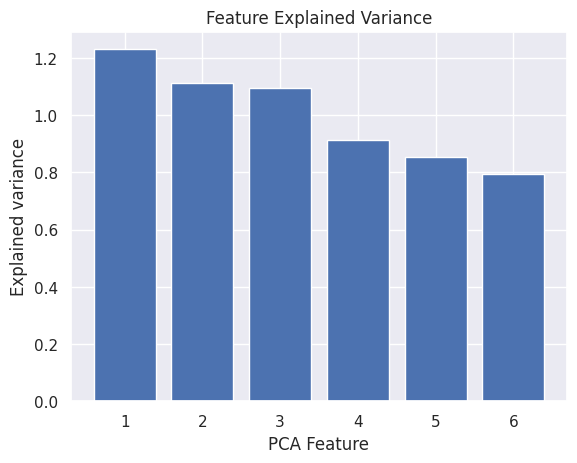

In [ ]:
sns.set()

# Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )


plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

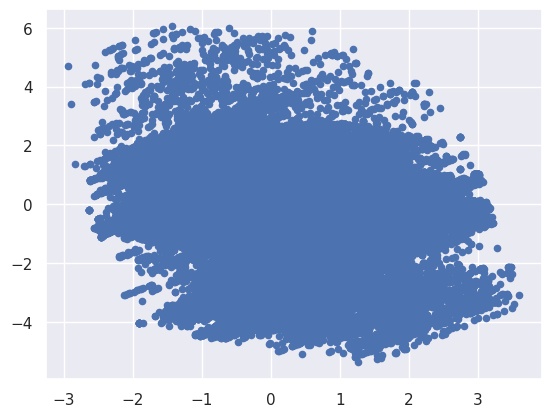

In [ ]:
pd.plotting.scatter_matrix(df)
plt.scatter(feature_train_data4[:, 0], feature_train_data4[:, 3], s = 20, cmap = 'summer')

In [ ]:
# Объект, в котором будет хранится информация о последовательном слиянии кластеров
#link = linkage(feature_train_data3, 'ward', 'euclidean')
# Функция для построения дендрограммы
#dn = dendrogram(link, orientation = "right")

model = KMeans(n_clusters=3)

# Проводим моделирование
model.fit(feature_train_data4)


# Предсказание на всем наборе данных
all_predictions = model.predict(feature_train_data4)

# Выводим предсказания

print(all_predictions)

[0 0 0 ... 0 0 0]


In [ ]:
#link = linkage(feature_train_data4, 'ward', 'euclidean')
# Функция для построения дендрограммы
#dn = dendrogram(link, orientation = "right")
# Останавливаем объединение, если расстояние между кластерами превышает 3
#all_predictions = fcluster(link, 3, criterion='distance')

In [ ]:
feature_train_data5 = pd.DataFrame(feature_train_data4)
feature_train_data5['cluster']=all_predictions

In [ ]:
pd.plotting.scatter_matrix(feature_train_data5, c = all_predictions)

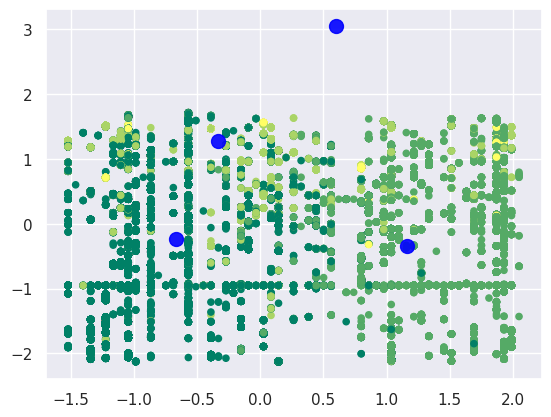

In [ ]:
y_kmeans = all_predictions
plt.scatter(feature_train_data5.iloc[:, 0], feature_train_data5.iloc[:, 2],c = y_kmeans,  s = 20, cmap = 'summer')
centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'blue', s = 100, alpha = 0.9);
plt.show()

## 6 Обучение моделей

In [388]:
#Инофрмация о работе моделей
columns = ['type',
    'best_model',
    'best_param',
    'RMSE_cross',
    'RMSE_valid',
    'time_train',
    'time_valid']
RMSE_models = []

#### 6.1 LightGBM

Данный бустинг работает быстро, попробуем с его помощью определить важность категориальных признаков и возможно удалить некоторые из них.

In [389]:
feature_train_data_lgbm = feature_train_data.copy()
feature_test_data_lgbm = feature_test_data.copy()
feature_test_lgbm= feature_test.copy()

for c in features_ohe:
    feature_train_data_lgbm[c] = feature_train_data_lgbm[c].astype('category')
    feature_test_data_lgbm[c] = feature_test_data_lgbm[c].astype('category')
    feature_test_lgbm[c] = feature_test[c].astype('category')

In [390]:
%%time
parameters = {
    'learning_rate':[0.03,0.1],
    'num_leaves': [ 257, 521],
    'n_estimators': [None,   200, 300],
    'max_depth' : [None, 10]
    }
#parameters = {
#    'learning_rate':[0.03],
#   'num_leaves': [ 521],
#   'n_estimators': [ 300]}


model_lgbm = find_best(LGBMRegressor, 5,feature_train_data_lgbm,
                       target_train_data, parameters, mean_absolute_percentage_error,
                       False, False)

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6598
[LightGBM] [Info] Number of data points in the train set: 264065, number of used features: 16
[LightGBM] [Info] Start training from score 13605.020699
[LightGBM] [Warning] No further splits with positiv

In [391]:
model_lgbm_best,importance_lgbm =  model_result(model_lgbm,
                                                feature_train_data_lgbm.columns)

Лучший показатель mape =  0.14406631371911893
Параметры лучшей модели  {'learning_rate': 0.03, 'max_depth': None, 'n_estimators': 300, 'num_leaves': 521}
                  0        1
8          odometer  2242300
2             model  2211600
11           seller  1979900
3              trim  1830200
15  mileage_per_day  1536600
7         condition  1471700
0              year  1353600
6             state   853600
14       month_sale   604600
1              make   481600
4              body   454600
9             color   200800
12          country   150200
10         interior    86500
5      transmission    81200
13        year_sale    61000


Удивительно, что seller имеет большую значимость, чем odometer. Возможно стоит убрать этот признак и попробовать обучить модель с лучшими параметрами  и посмотреть результат.

In [ ]:
parameters = {
    'learning_rate':[0.03],
    'num_leaves': [ 521],
    'n_estimators': [300]
    }

feature_train_data_lgbm2 = feature_train_data_lgbm.drop('seller', axis = 1)
feature_test_data_lgbm2 = feature_test_data_lgbm.drop('seller', axis = 1)
feature_test_lgbm2= feature_test_lgbm.drop('seller', axis = 1)

In [ ]:
%%time
model_lgbm2 = find_best(LGBMRegressor, 5,feature_train_data_lgbm2,
                       target_train_data, parameters, mean_absolute_percentage_error,
                       False, False)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2121
[LightGBM] [Info] Number of data points in the train set: 264065, number of used features: 15
[LightGBM] [Info] Start training from score 13618.356496
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036880 seconds.
You can set `forc

In [ ]:
model_lgbm_best2,importance_lgbm2 =  model_result(model_lgbm2,
                                                feature_train_data_lgbm2.columns)

Лучший показатель mape =  0.15355195368459051
Параметры лучшей модели  {'learning_rate': 0.03, 'n_estimators': 300, 'num_leaves': 521}
                  0        1
8          odometer  2528800
2             model  2429000
3              trim  2044800
14  mileage_per_day  1802500
7         condition  1671400
0              year  1549600
6             state  1231200
13       month_sale   684700
1              make   450900
4              body   382500
9             color   305400
11          country   207600
10         interior   131100
5      transmission   111200
12        year_sale    69300


Метрика стала больше, а значит модель предсказывает лучше при наличии признака seller.
Оставим его. Удивительно, что transmission имеет небольшую значимость, хотя интуитивно ожидается, что этот признак должен быть значим (машины на механике ощутимо дешевле). Возможно влияют пропуски в данных, которые мы не смогли заполнить по имеющимся данным, заполнив их заглушкой.

 Столбец 'color' также имеет небольшую значимость, но цвет машины может влиять на цену, так белые машины дешевле. Попробуем изменить столбец color: 0 если машина белого цвета, 1 - если другого.

In [235]:
parameters = {
    'learning_rate':[0.03,0.1],
    'num_leaves': [31, 257, 521],
    'n_estimators': [None,  100, 300],
    'max_depth' : [None, 10]}
#parameters = {
##    'learning_rate':[0.03],
 #   'num_leaves': [ 521],
 #   'n_estimators': [ 300]}

feature_train_data_lgbm3 = data_no_color(feature_train_data_lgbm)
feature_test_data_lgbm3 = data_no_color(feature_test_data_lgbm)
feature_test_lgbm3= data_no_color(feature_test_lgbm)

In [236]:
%%time
model_lgbm3 = find_best(LGBMRegressor, 5,feature_train_data_lgbm3,
                       target_train_data, parameters, mean_absolute_percentage_error,
                       False, False)

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [237]:
model_lgbm_best3,importance_lgbm3 =  model_result(model_lgbm3,
                                                feature_train_data_lgbm3.columns)

Лучший показатель mape =  0.14364036232310876
Параметры лучшей модели  {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 300, 'num_leaves': 521}
                  0        1
8          odometer  2835800
13  mileage_per_day  2608900
7         condition  1857800
10           seller  1730500
2             model  1416800
3              trim  1282600
0              year   984300
6             state   854100
12       month_sale   847000
1              make   498600
4              body   330200
9             color   190800
11          country   108500
5      transmission    54100


Бинарный признак цвета дает лучшую предсказательную способность.

#### 6.2 CatBoostRegressor

CatBoost обычно хорошо работает и без настройки гиперпараметров, но намного дольше обучается, чем LGBMRegressor.

In [166]:
%%time
parameters = {
    'cat_features': [features_ohe],
    'learning_rate': [0.03,0,5, 0.1],
    'depth': [8],

    }

#parameters = {
#    'cat_features': [features_ohe],
##    'l2_leaf_reg': [ 5],
 #   'depth': [8]

 #   }



model_cat = find_best(CatBoostRegressor, 2,feature_train_data,
                      target_train_data, parameters, mean_absolute_percentage_error,
                       True, False)

0:	learn: 9551.1636795	total: 2.21s	remaining: 36m 48s
999:	learn: 2426.2304565	total: 9m 14s	remaining: 0us
0:	learn: 9527.1322269	total: 1.12s	remaining: 18m 37s
999:	learn: 2434.7180378	total: 9m 5s	remaining: 0us


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 32850.9950622	total: 579ms	remaining: 9m 38s


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 32170.3505654	total: 565ms	remaining: 9m 24s
0:	learn: 9088.2751409	total: 576ms	remaining: 9m 35s
999:	learn: 1906.7995169	total: 9m 18s	remaining: 0us
0:	learn: 9084.6371893	total: 563ms	remaining: 9m 22s
999:	learn: 1914.0184685	total: 9m 11s	remaining: 0us
0:	learn: 9052.9346015	total: 1.16s	remaining: 19m 16s
999:	learn: 1910.0830022	total: 17m 18s	remaining: 0us
CPU times: user 1h 39min 15s, sys: 1min 6s, total: 1h 40min 22s
Wall time: 59min 36s


In [167]:
model_cat_best,importance_cat =  model_result(model_cat,
                                                feature_train_data.columns)

Лучший показатель mape =  0.1810010273651874
Параметры лучшей модели  {'cat_features': ['model', 'make', 'state', 'color', 'interior', 'country', 'transmission', 'seller', 'body', 'trim'], 'depth': 8, 'learning_rate': 0.1}
                  0        1
2             model   1739.5
0              year  1577.48
8          odometer  1484.42
1              make  1303.62
12          country  1276.84
4              body   835.91
3              trim   709.77
7         condition   461.43
11           seller    159.2
10         interior   102.35
15  mileage_per_day    97.29
5      transmission    82.25
6             state    69.69
14       month_sale    67.17
9             color    27.54
13        year_sale     5.53


#### 6.3 Лучшая модель

Лучшая модель LGBMRegressor.
Сохраним ее.

In [ ]:
filename = 'model_lgbm3.sav'
model_lgbm_best3.booster_.save_model('model_lgbm_best3.txt')

['model_lgbm3_2508.sav']

## 7. Проверка тестовой модели

#### 7.1 Тестирование модели

In [ ]:
#load from model:
#model = lightgbm.Booster(model_file='model_lgbm_best3.txt')

In [393]:
%%time
pred_test = model_lgbm_best3.predict(feature_test_data_lgbm3)
mape_test = (mean_absolute_percentage_error(target_test_data,pred_test))
mape_test

CPU times: user 32.3 s, sys: 43.6 ms, total: 32.3 s
Wall time: 38.4 s


0.23436971207832438

Запишем данные в тестовый набор - sample_submission

In [233]:
#sample_sub = pd.read_csv('/kaggle/input/used-cars-price-prediction-22ds/sample_submission.csv')
pred_test = model_lgbm_best.predict(feature_test_lgbm)
sample_sub['sellingprice'] = pred_test
sample_sub.head(5)

vin  sellingprice
0  1g6dp567450124779   4270.329779
1  1gtw7fca7e1902207  22301.579736
2  jn8az1mw6dw303497  18653.439869
3  2g1wf5e34d1160703   9314.890996
4  1n6aa0ec3dn301209  22917.349024

In [234]:
sample_sub.to_csv('sample_sub18.csv', index= False)
print('successful')

successful


Вывод:
1. Данные были очищены, пропуски заполнены, по столбцу vin заполнена пропущенная информация (марка автомобиля), а также информация о стране производителе.
2. Добавлены новые признаки: год продажи, месяц продажи, пробег в день, возраст в днях.
3. Удалены признаки с корреляцией более 0,8 (возраст автомобиля в днях.).
4. На примере линейной регрессии показано, что добавленные признаки повышают метрику R2, а значит долю дисперсии зависимой переменной, объясняемой рассматриваемой моделью (на вхрд подавались числовые признаки).
5. Попытка с помощью классифицирующей модели (k-means)  предсказать класс автомобиля (эконом - премиум) не повысила точности метрики mape. Класс автомобиля выбирался согласно анализу гистограмы.
6. Анализ категориальных признаков и попытка кластеризовать категориальные признаки с помощью kmeans не повысили метрику mape. Попытка отобразить категориальные переменные после их преобразования с помощью OrdinalEncoder  и последушего выделения главных компонент не дал результата.  
7. После анализа было решено оставить следующие признаки:, а признак цвета закодировать (0- цвет белый, 1 - другой).
8. Обучены модели граиднтного бустинга. Лучшей моделью оказалсась модель LightGBM.
9. Оценка mape  на тестовом наборе дала результат 0.23.
